In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.optimize as op
import matplotlib.pyplot as plt

import io
from scipy.interpolate import UnivariateSpline

In [3]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def mnk(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    return dat#, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

def mnkerr(x, y):
    p = np.polyfit(x, y, 1)
    cov = np.cov(x, y)
    da = (1/(len(x) - 2) * (cov[1][1]/cov[0][0] - p[0]**2))**(0.5)
    db = da * (x**2).mean()
    return [da, db]

In [4]:
class dataset:
    def __init__(self, df, label):
        self.df    = df
        self.label = label
        self.D     = 0
        self.sD    = 0
        
    def U(self):
        return np.delete(np.array(self.df['V (mV)'], dtype=np.double), ignore)
    def t(self):
        return np.delete(np.array(self.df['t (s)'],  dtype=np.double), ignore)
    

In [5]:
data = { 
    '40'  : dataset(pd.read_csv("data/40-44.5.csv"),   '44.5 торр'),
    '80'  : dataset(pd.read_csv("data/80-81.7.csv"),   '81.7 торр'),
    '120' : dataset(pd.read_csv("data/120-133.7.csv"), '133.7 торр'),
    '160' : dataset(pd.read_csv("data/160-170.9.csv"), '170.9 торр'),
    '200' : dataset(pd.read_csv("data/200-208.2.csv"), '208.2 торр'),
}

In [6]:
ignore = ()

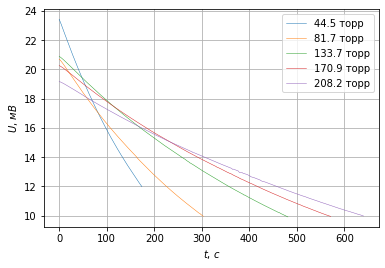

In [7]:
LW = 0.5

for i, d in data.items():
    plt.plot(d.t(), d.U(), label=d.label, linewidth=LW)

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$U$, $мВ$")

plt.grid(True)
plt.legend()
plt.savefig('res/U_T.pdf')

44.5 торр [(-0.003854654804986957, 2.4913687282753328e-06), (3.1520069671505837, 0.025211937852760116)]
D =  7.285297581425349 +- 0.19147557685428337 2.6282464746871974 % 

81.7 торр [(-0.0024270265609879628, 5.224415795608445e-07), (3.0338131164625883, 0.016027895727300883)]
D =  4.58708020026725 +- 0.12052735887495772 2.627539820819693 % 

133.7 торр [(-0.0015507651171510787, 4.320579386105721e-07), (3.038997421179488, 0.033354777287289944)]
D =  2.930946071415539 +- 0.07701352008964418 2.627599355741455 % 

170.9 торр [(-0.0012444414407020742, 6.744415621237092e-07), (3.003696856578762, 0.07340489989998113)]
D =  2.3519943229269202 +- 0.06181065864044923 2.6280105371823117 % 

208.2 торр [(-0.0010179084080956325, 3.7129092946127526e-07), (2.9509621910544097, 0.05076826228157966)]
D =  1.9238468913007454 +- 0.050553017526935785 2.6277048218091843 % 



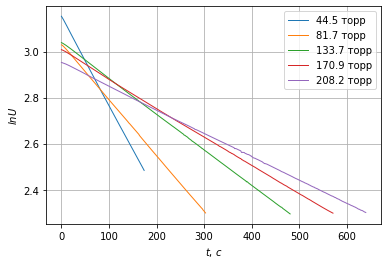

In [8]:
LW = 1

for i, d in data.items():
    plt.plot(d.t(), np.log(d.U()), label=d.label, linewidth=LW)
    p = np.polyfit(d.t(),  np.log(d.U()), 1)
    err = mnkerr(d.t(),  np.log(d.U()));
    d.D  = -p[0] * 420 * 9 / 2
    pct = np.linalg.norm(np.array([10/420, 0.1/9, err[0]/p[0]]))
    d.sD = d.D * pct
    print(d.label, list(zip(p, err)))
    print('D = ', d.D, '+-', d.sD, 100*pct, '%', '\n')

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$ln U$")
plt.grid(True)
    
plt.legend()
plt.savefig('res/lnU_T.pdf')

In [9]:
D = np.array([7.285297581425349, 4.5870802002672235, 2.9309460714155553, 2.351994322926922, 1.9238468913007396])
SD = np.array([0.19147557685428257, 0.12052735887496027, 0.07701352008964342, 0.06181065864044914, 0.050553017526935966])
P = np.array([44.5, 81.7, 133.7, 170.9, 208.2])

Coeffs: [(355.1096117185043, 5.937082373170092), (0.25196132760188633, 0.0003904599541904493)]
При атмосфере ( 0.0013189132155104193 ) 0.7203200874521953 +- 0.00784020624231703


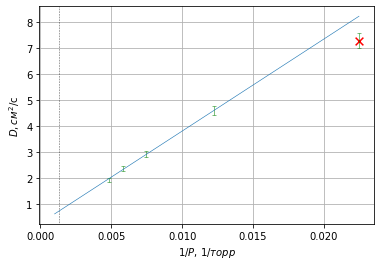

In [10]:
ign = ()
plt.errorbar(1/P, D, yerr =1.5* SD, fmt=' ', c='green', capsize=2, elinewidth=0.5, markeredgewidth=0.5)

ign = (0)
plt.scatter(np.take(1/P, ign), np.take(D, ign), s=60, marker='x', c='r')
p = np.polyfit(np.delete(1/P, ign), np.delete(D, ign), 1)
err = mnkerr(np.delete(1/P, ign), np.delete(D, ign))
print('Coeffs:', list(zip(p, err)))

t = np.linspace(0.0010, 1/P.min())
plt.axvline(x = 1/758.2, linestyle=':', c='black', linewidth=0.6)
plt.plot(t, np.polyval(p, t), linewidth=0.6)

plt.xlabel(r"$1/P$, $1/торр$")
plt.ylabel(r"$D,$$см^2$/c")
plt.grid(True)

plt.savefig('res/D_1P.pdf')
print('При атмосфере (', 1/758.2, ')', np.polyval(p, 1/758.2), '+-',
     np.linalg.norm(np.array([err[1], err[0]*0.00131891])))

In [11]:
lamb = 3 * 0.72032008745e-4 * (3.14 * 4e-3/ (8 * 8.31 * (273 + 24)))**0.5
pct = 0.0156 / 0.72032
dlamb = pct * lamb

lamb *1e9
print("lambda = ", lamb *1e9, '+-', pct * lamb, pct*100,'%')

lambda =  172.35261235806018 +- 3.732647646581712e-09 2.1657041314971126 %


In [12]:
sigma = 1.83e-23*(24+273)/(1e5 * lamb)
print("sigma = ", sigma, '+-', pct * sigma, pct * 100,'%')

sigma =  3.1534770060279994e-19 +- 6.829498180535983e-21 2.1657041314971126 %
